len(train_samples) =  16741
len(validation_samples) =  4186


Using TensorFlow backend.
C:\Users\Robert\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\legacy\interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu")`
  '` call to the Keras 2 API: ' + signature)
C:\Users\Robert\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\legacy\interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  '` call to the Keras 2 API: ' + signature)
C:\Users\Robert\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\legacy\interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  '` call to the Keras 2 API: ' + signature)


len(train_samples) =  16741
len(validation_samples) =  4186
epoches =  10
steps_per_epoch =  130.7890625
Epoch 1/10
131/130 [==============================] - 703s - loss: 0.0125 - val_loss: 0.0074
Epoch 2/10
131/130 [==============================] - 700s - loss: 0.0077 - val_loss: 0.0077
Epoch 3/10
131/130 [==============================] - 700s - loss: 0.0071 - val_loss: 0.0065
Epoch 4/10
131/130 [==============================] - 700s - loss: 0.0064 - val_loss: 0.0062
Epoch 5/10
131/130 [==============================] - 699s - loss: 0.0058 - val_loss: 0.0062
Epoch 6/10
131/130 [==============================] - 701s - loss: 0.0054 - val_loss: 0.0064
Epoch 7/10
131/130 [==============================] - 701s - loss: 0.0049 - val_loss: 0.0058
Epoch 8/10
131/130 [==============================] - 726s - loss: 0.0044 - val_loss: 0.0059
Epoch 9/10
131/130 [==============================] - 733s - loss: 0.0038 - val_loss: 0.0059
Epoch 10/10
131/130 [==============================] - 741

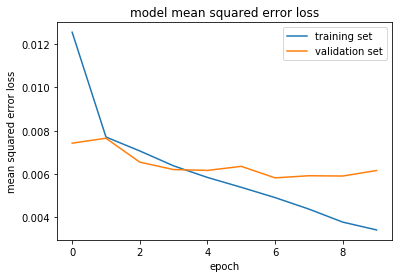

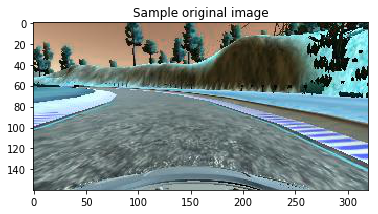

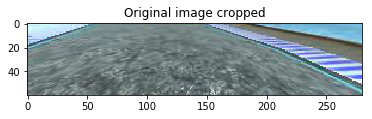

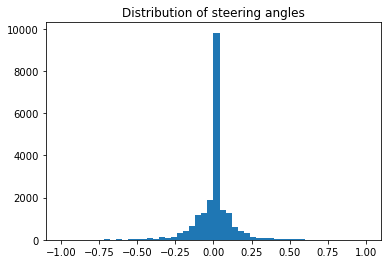

In [1]:
import csv
import cv2
import numpy as np
import re
import matplotlib.pyplot as plt 
import h5py
import os
import sklearn
import random as rand

samples = []
lines = []
histograms = []

with open('IMG/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    k = 0
    for line in reader:
        lines.append(line)
        #below is for building small code testing set
        if k < 1:
            picture = cv2.imread(line[0])
             
        k = k + 1
        #if k > 100:
           # break
        histogram = float(line[3])
        histograms.append(histogram)


batch_size = 128
test_size = 0.2
epoches = 10

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(lines, test_size=test_size)

i = 0
      
def generator(iterlines, batch_size = batch_size):
    num_samples = len(iterlines)
    #print(" ")
    
    #print("num_samples = ",num_samples)
    while 1: # Loop forever so the generator never terminates
        rand.shuffle(iterlines)
        i = 0
        for offset in range(0, num_samples, batch_size):
            batch_samples = iterlines[offset:offset+batch_size]
            #print("len(batch_samples) = ",len(batch_samples))
            images = []
            measurements = []
            i = i + 1
            #print("i = ",i)
            j = 0
            for line in batch_samples:
                source_path = line
               
                # the following two lines convert the cv2 BGR image to the RGB image that drive.py uses
                image_BGR = cv2.imread(source_path[0])
                image = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB)
    
                images.append(image)
    
                measurement = float(source_path[3])
                measurements.append(measurement)
                # code below is for verifying that the image is loading correctly
                #f i > 0:
                    #cv2.imshow('image',image_BGR)
                    #cv2.waitKey(0)
                # end of comment
                j = j + 1
                #print("j = ",j)
                augmented_images, augmented_measurements = [], []
                
                augmented_images.append(image)
                augmented_measurements.append(measurement)
                augmented_images.append(cv2.flip(image,1))# flips image left to right to simulate card driving other way around track
                augmented_measurements.append(measurement*(-1.0))# to get the steering measurements reveresed for driving the other direction

                images.extend(augmented_images)
                measurements.extend(augmented_measurements)


            X_train = np.array(images)
            y_train = np.array(measurements)
            #print("X_train.shape = ",X_train.shape)
            #print("y_train.shape = ",y_train.shape)
            yield sklearn.utils.shuffle(X_train, y_train)
#end of generator


print("len(train_samples) = ",len(train_samples))
print("len(validation_samples) = ",len(validation_samples))
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)


from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Cropping2D
import cv2

#ch, row, col = 3, 80, 320 #trimmed image format 

model = Sequential()

model.add(Lambda(lambda x: x /255.0 - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((75,25), (20,20)), input_shape=(160,320,3)))


model.add(Convolution2D(16,3,3,activation="relu"))
model.add(MaxPooling2D())

model.add(Convolution2D(32,3,3,activation="relu"))
model.add(MaxPooling2D())
model.add(Convolution2D(64,3,3,activation="relu"))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(400, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))



#model.add(Flatten(input_shape=(160,320,3)))
#model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
print("len(train_samples) = ",len(train_samples))
print("len(validation_samples) = ",len(validation_samples))
print("epoches = ",epoches)
print("steps_per_epoch = ",len(train_samples)/batch_size)
history_object = model.fit_generator(train_generator, steps_per_epoch = len(train_samples)/batch_size, validation_data = 
                                     validation_generator, validation_steps = len(validation_samples)/batch_size,
                                     epochs=epoches,verbose=1)


#history_object = model.fit_generator(train_generator, samples_per_epoch= len(train_samples), 
                                     #validation_data=validation_generator, 
                                     #nb_val_samples=len(validation_samples), nb_epoch=3)
#history_object = model.fit(X_train, y_train,validation_split=0.3,shuffle=True, epochs=10, verbose = 1)

print(history_object.history.keys())
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

plt.imshow(picture)
plt.title("Sample original image")
plt.show()

cropped = picture[75:135, 20:300]

plt.imshow(cropped)
plt.title("Original image cropped")
plt.show()

plt.hist(histograms, bins=50)
plt.title("Distribution of steering angles")
plt.show()

model.save('model.h5')
